# Define the system  

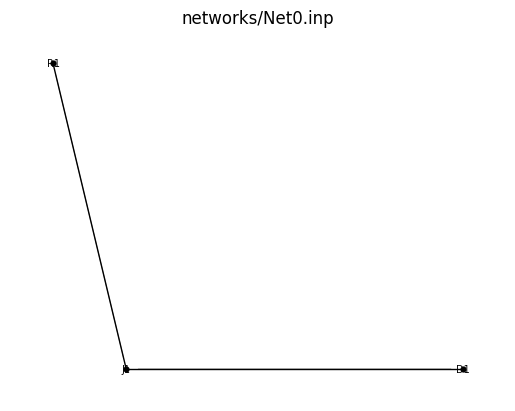

In [1]:
import wntr
import wntr_quantum

# Create a water network model
inp_file = 'networks/Net0.inp'
# inp_file = 'networks/Net2Loops.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)

wn.options.hydraulic.headloss = 'H-W'


## Run with the original simulator

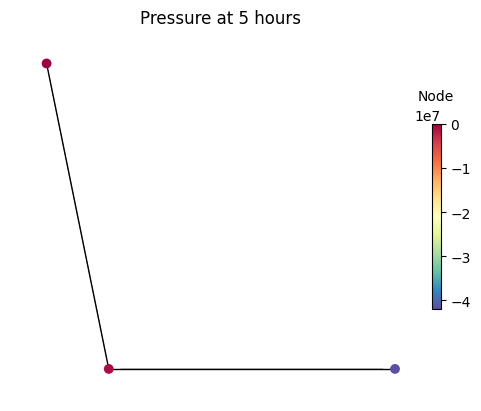

<Axes: title={'center': 'Pressure at 5 hours'}>

In [2]:
# define the classical simulator
sim = wntr.sim.EpanetSimulator(wn)

# run the simulation
results = sim.run_sim()

# Plot results on the network
pressure_at_5hr_ref = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr_ref, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

## Run with the VQLS solver

In [3]:
from quantum_newton_raphson.vqls_solver import VQLS_SOLVER
from qiskit.primitives import Estimator
from qiskit.circuit.library import RealAmplitudes 
from qiskit_algorithms import optimizers as opt

# define the ansatz
qc = RealAmplitudes(2, reps=3, entanglement='full')

# define the estimator : WARNING This is redefined in vqls_solver becauseof a qiskit bug
estimator = Estimator()

linear_solver = VQLS_SOLVER(
    estimator=estimator,
    ansatz = qc,
    optimizer=[opt.COBYLA(maxiter=1000, disp=True), opt.CG(maxiter=500, disp=True)],
    matrix_decomposition="pauli",
)


# define the quantum epanet simulator
sim = wntr_quantum.sim.QuantumWNTRSimulator(wn, linear_solver=linear_solver)

# run the simulation
results = sim.run_sim(linear_solver=linear_solver)

# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

Matrix
[[ 1.000e+00 -1.000e+00 -5.412e+07  0.000e+00]
 [ 0.000e+00  0.000e+00 -1.000e+00  0.000e+00]
 [-1.000e+00  0.000e+00  0.000e+00 -1.207e+06]
 [ 0.000e+00  0.000e+00  1.000e+00 -1.000e+00]]
RHS
[-2.922e+04  4.900e-02 -6.219e+02  0.000e+00]
[-5.978e+04 -2.741e+06  4.900e-02  4.900e-02]


/Users/murilo/Library/CloudStorage/OneDrive-NetherlandseScienceCenter/Documents/NLeSC_Projects/Vitens/wntr-quantum/.venv/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/Users/murilo/Library/CloudStorage/OneDrive-NetherlandseScienceCenter/Documents/NLeSC_Projects/Vitens/QuantumNewtonRaphson/quantum_newton_raphson/preconditioners.py:118: RuntimeWarning: invalid value encountered in sqrt
  sqrt_diag_A = np.sqrt(diag_A)


RuntimeError: Factor is exactly singular

## Compare the pressure values obtained

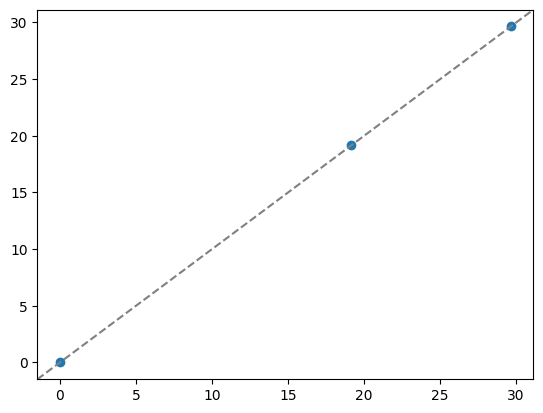

In [ ]:
import matplotlib.pyplot as plt 
plt.scatter(pressure_at_5hr_ref.values, pressure_at_5hr.values)
plt.axline((0, 0), slope=1, linestyle="--", color="gray")
plt.show()